In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import os
import tensorboard
import tensorflow.keras.layers as nn
import datetime

In [2]:
if len(os.listdir("data/")) == 0:
    file = tarfile.open("images.tar")
    file.extractall("data/")
    print("Extraction completed")
    file.close()

class_name = os.listdir('data/Images/')
batch_size = 32
IMG_SIZE = 224

file_path = []
label = []

for idx , name in enumerate(class_name):
    for image_name in os.listdir('data/Images/'+name):
        file_path.append('data/Images/'+name+'/'+image_name)
        label.append(idx)

total_images = len(file_path)
total_images

20580

In [3]:
dataset = tf.data.Dataset.from_tensor_slices((file_path, label))

def file_to_img(x, y):
    image = tf.io.read_file(x)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    
    return image, tf.reshape(y, (-1,1))

def ds_configuration(ds):
    ds = ds.map(file_to_img, num_parallel_calls = tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


def get_dataset_partitions_tf(ds, ds_size=total_images, train_split=0.9, val_split=0.04, test_split=0.06, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    ds = ds.skip(train_size)   
    val_ds = ds.take(val_size)
    ds = ds.skip(val_size)
    test_ds = ds
    
    return train_ds, val_ds, test_ds

train_data_loader, validation_data_loader, test_data_loader = get_dataset_partitions_tf(dataset, total_images, 0.9, 0.02, 0.08, True, total_images)

train_data_loader = ds_configuration(train_data_loader)
validation_data_loader = ds_configuration(validation_data_loader).cache()
test_data_loader = ds_configuration(test_data_loader)


In [4]:
print(tf.data.experimental.cardinality(train_data_loader).numpy(), tf.data.experimental.cardinality(validation_data_loader).numpy(), tf.data.experimental.cardinality(test_data_loader).numpy())

579 13 52


In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

resnet_model = ResNet50(weights='imagenet')
for layer in resnet_model.layers:
    layer.trainable = False

i = nn.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = preprocess_input(i)
x = resnet_model(x)
x = nn.Dense(len(class_name), activation='softmax')(x)

model = tf.keras.Model(inputs = [i], outputs = [x])
model.summary()

augment = tf.keras.Sequential([nn.RandomFlip(),
	                           nn.RandomRotation(factor=1/8)
								]) #+-45


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
dense (Dense)                (None, 120)               120120    
Total params: 25,756,832
Trainable params: 120,120
Non-trainable params: 25,636,712
_________________________________________________________________


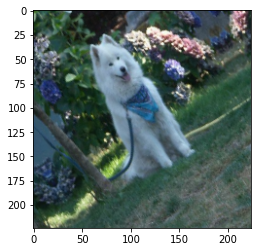

In [6]:
for x,y in validation_data_loader.take(1):
	x = augment(x)
	plt.imshow(x[0].numpy().astype(np.int32))
	plt.show()
	
	break

In [7]:
loss_history = [[],[]] #[[train], [test]]
acc_history = [[],[]]
EPOCHS = 20
batch_size = 32
n_train_batches = int(0.9*total_images)//batch_size
n_test_batches = int(0.04*total_images)//batch_size
log_per_epoch = 3

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
loss_metrics = tf.keras.metrics.SparseCategoricalCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'log/metrics/' + current_time + '/train'
test_log_dir = 'log/metrics/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    accuracy(labels, predictions)
    loss_metrics(labels, predictions)

@tf.function
def test_step(images, labels):
    predictions = model(images, training=False)
    loss = loss_object(labels, predictions)

    accuracy(labels, predictions)
    loss_metrics(labels, predictions)


for epoch in range(EPOCHS):
    print(f"----------------EPOCH {epoch+1}---------------------------")
    with tf.device('/device:gpu:0'):
        for batch_idx , (images, labels) in  enumerate(train_data_loader):
            images = augment(images)
            train_step(images, labels)

            loss_history[0].append(loss_metrics.result())
            acc_history[0].append(accuracy.result())

            accuracy.reset_state()
            loss_metrics.reset_state()

            if batch_idx%(n_train_batches//log_per_epoch) == 0:
                print(f"BATCH {batch_idx}/{n_train_batches} TRAIN LOSS : {loss_history[0][-1]} TRAIN ACCURACY : {acc_history[0][-1]}")

            with train_summary_writer.as_default():
                tf.summary.scalar('batch_loss', loss_history[0][-1], step=n_train_batches*epoch+batch_idx)
                tf.summary.scalar('batch_accuracy', acc_history[0][-1], step=n_train_batches*epoch+batch_idx)

        for batch_idx, (images, labels) in enumerate(validation_data_loader):
            test_step(images, labels)
            loss_history[1].append(loss_metrics.result())
            acc_history[1].append(accuracy.result())

            accuracy.reset_state()
            loss_metrics.reset_state()

    print(f"----------------EPOCH {epoch+1} STATISTICS-----------------")
    print(f"FINAL TRAIN LOSS : {loss_history[0][-1]} TRAIN ACC : {acc_history[0][-1]}")
    print(f"AVERAGE TRAIN LOSS : {sum(loss_history[0][-n_train_batches:])/n_train_batches} TRAIN ACC : {sum(acc_history[0][-n_train_batches:])/n_train_batches}")
    print(f"TEST LOSS : {sum(loss_history[1][-n_test_batches:])/n_test_batches} TEST ACC : {sum(acc_history[1][-n_test_batches:])/n_test_batches}")
    print(f"--------------------------------------------------\n")

    with train_summary_writer.as_default():
        tf.summary.scalar('loss', sum(loss_history[0][-n_train_batches:])/n_train_batches, step=epoch+1)
        tf.summary.scalar('accuracy', sum(acc_history[0][-n_train_batches:])/n_train_batches, step=epoch+1)

    with test_summary_writer.as_default():
        tf.summary.scalar('loss', sum(loss_history[1][-n_test_batches:])/n_test_batches, step=epoch+1)
        tf.summary.scalar('accuracy', sum(acc_history[1][-n_test_batches:])/n_test_batches, step=epoch+1)



----------------EPOCH 1---------------------------
BATCH 0/578 TRAIN LOSS : 4.7836198806762695 TRAIN ACCURACY : 0.0
BATCH 192/578 TRAIN LOSS : 4.206899642944336 TRAIN ACCURACY : 0.28125
BATCH 384/578 TRAIN LOSS : 3.3504772186279297 TRAIN ACCURACY : 0.4375
BATCH 576/578 TRAIN LOSS : 2.944409132003784 TRAIN ACCURACY : 0.40625
----------------EPOCH 1 STATISTICS-----------------
FINAL TRAIN LOSS : 2.9278972148895264 TRAIN ACC : 0.5769230723381042
AVERAGE TRAIN LOSS : 3.6689579486846924 TRAIN ACC : 0.4466620981693268
TEST LOSS : 1.0167899131774902 TEST ACC : 0.4230555593967438
--------------------------------------------------

----------------EPOCH 2---------------------------
BATCH 0/578 TRAIN LOSS : 2.575049638748169 TRAIN ACCURACY : 0.59375
BATCH 192/578 TRAIN LOSS : 2.6191208362579346 TRAIN ACCURACY : 0.53125
BATCH 384/578 TRAIN LOSS : 2.2587332725524902 TRAIN ACCURACY : 0.53125
BATCH 576/578 TRAIN LOSS : 2.0570414066314697 TRAIN ACCURACY : 0.65625
----------------EPOCH 2 STATISTICS---

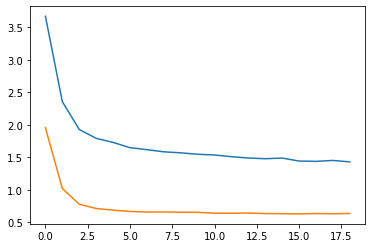

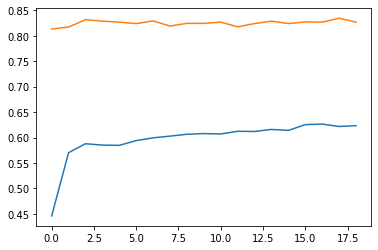

In [9]:
train_n_minibatches,n_validation_losses= tf.data.experimental.cardinality(train_data_loader).numpy(), tf.data.experimental.cardinality(validation_data_loader).numpy()
import seaborn as sns
# Plotting Loss per epoch
loss_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in loss_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    loss_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in loss_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    loss_per_epoch[1].append(temp/n_validation_losses)    

plt.plot(range(len(loss_per_epoch[0])),loss_per_epoch[0])
plt.plot(range(len(loss_per_epoch[1])),loss_per_epoch[1])
plt.show()



# Plotting Accuracy per epoch
accuracy_per_epoch = [[],[]]
for i in range(epoch):
    temp = 0
    for j in acc_history[0][i*train_n_minibatches:(i+1)*train_n_minibatches]:
        temp = temp + j
    accuracy_per_epoch[0].append(temp/train_n_minibatches)
    temp = 0
    for j in acc_history[1][i*n_validation_losses:(i+1)*n_validation_losses]:
        temp = temp + j
    accuracy_per_epoch[1].append(temp/n_validation_losses)    

plt.plot(range(len(accuracy_per_epoch[0])),accuracy_per_epoch[0])
plt.plot(range(len(accuracy_per_epoch[1])),accuracy_per_epoch[1])
plt.show()

In [11]:
print("BEST TEST ACC:" ,max(acc_history[1]).numpy())
print("BEST TRAIN ACC:" ,max(acc_history[0]).numpy())

BEST TEST ACC: 0.9375
BEST TRAIN ACC: 0.90625
